# Conversational Threads

Many LLM applications have a chatbot-like interface in which the user and the LLM application engage in a multi-turn conversation. In order to track these conversations, you can use the Threads feature in LangSmith.

This is relevant to our RAG application, which should maintain context from prior conversations with users.

### Setup

In [ ]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/Lenovo/Documents/code/mat496/.env", override=True)

True

In [2]:
import os
if "LANGSMITH_TRACING_V2" in os.environ:
    del os.environ["LANGSMITH_TRACING_V2"]
os.environ["LANGSMITH_TRACING_V2"] = "true"

In [3]:
import os
print("LANGSMITH_API_KEY set:", "LANGSMITH_API_KEY" in os.environ)
print("LANGSMITH_TRACING_V2:", os.environ.get("LANGSMITH_TRACING_V2"))

LANGSMITH_API_KEY set: True
LANGSMITH_TRACING_V2: true


In [4]:
from langsmith import utils
utils.tracing_is_enabled()

True

### Group traces into threads


A Thread is a sequence of traces representing a single conversation. Each response is represented as its own trace, but these traces are linked together by being part of the same thread.

To associate traces together, you need to pass in a special metadata key where the value is the unique identifier for that thread.

The key value is the unique identifier for that conversation. The key name should be one of:

- session_id
- thread_id
- conversation_id.

The value should be a UUID.

In [11]:
import uuid
thread_id = uuid.uuid4()

In [23]:
from langsmith import traceable
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever
from langchain.schema import Document

nest_asyncio.apply()

# Get retriever 
retriever = get_vector_db_retriever()

# Then add custom document
custom_doc = Document(
    page_content="The lady wearing the blue jacket went into the Gucci store. She brought 2 watches and a scarf. The man went into the shoe store and got 3 pairs of nike shoes",
    metadata={"source": "custom", "title": "My Custom Doc"}
)

# Access the vector store and add document
vector_store = retriever.vectorstore
vector_store.add_documents([custom_doc])

# Initialize LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

#@traceable(run_type="chain",enabled=True)
def retrieve_documents(question: str):
    return retriever.invoke(question)

#@traceable(run_type="chain",enabled=True)
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the latest question in the conversation.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.
    """
    messages = [
        {
            "role": "user",
            "content": f"{rag_system_prompt}\n\nContext: {formatted_docs}\n\nQuestion: {question}"
        }
    ]
    return call_gemini(messages)

#@traceable(run_type="llm",enabled=True)
def call_gemini(
    messages: List[dict], model: str = "gemini-2.0-flash", temperature: float = 0.0
) -> str:
    return llm.invoke(messages)
@traceable(run_type="chain",enabled=True)
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content

### Now let's run our application twice with this thread_id

In [21]:
langsmith_rag(
    "What did the lady buy?",
    langsmith_extra={"metadata": {"thread_id": str(thread_id)}}
)
print(ai_answer)

The man went into the shoe store. He bought 3 pairs of Nike shoes.


In [22]:
langsmith_rag(
    "What did the ther person buy?",
    langsmith_extra={"metadata": {"thread_id": str(thread_id)}}
)
print(ai_answer)

The man went into the shoe store. He bought 3 pairs of Nike shoes.


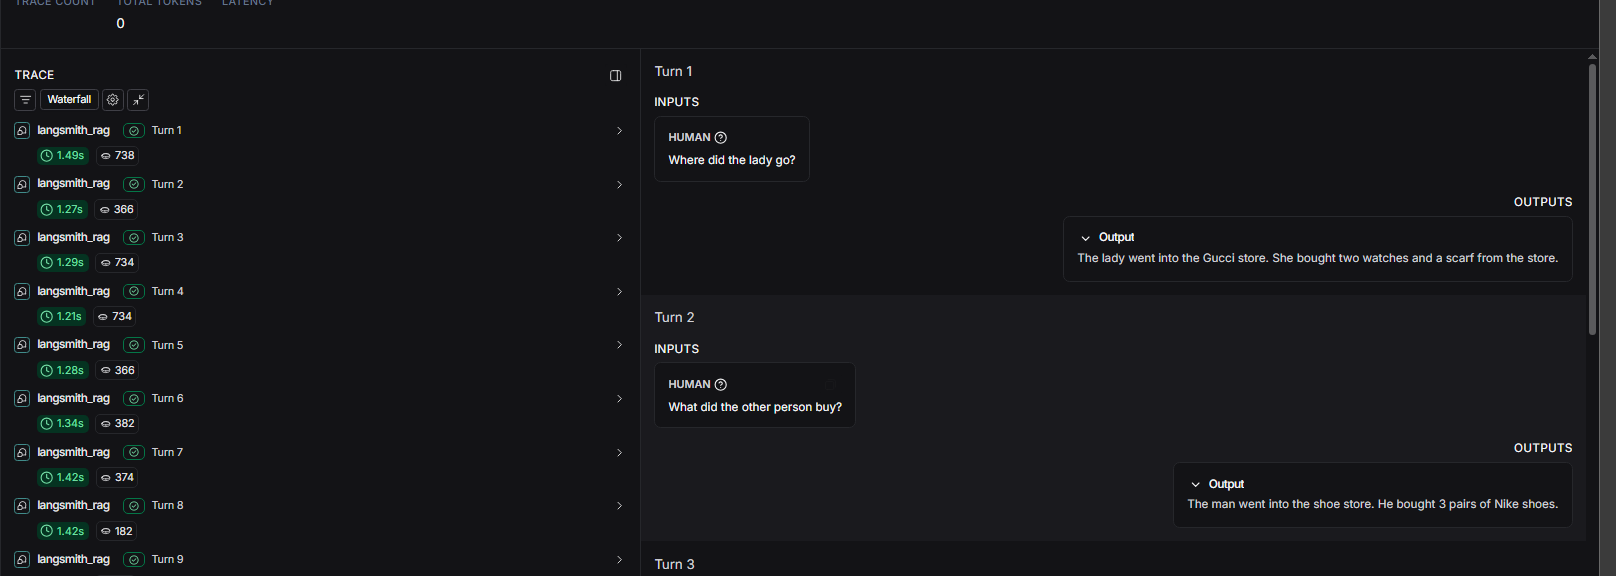

### Let's take a look in LangSmith!